###  `Fbeta_binary` for text classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

#### Load sample text

In [4]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/wyquek/.fastai/data/imdb_sample/tmp_clas'),
 PosixPath('/home/wyquek/.fastai/data/imdb_sample/models'),
 PosixPath('/home/wyquek/.fastai/data/imdb_sample/texts.csv'),
 PosixPath('/home/wyquek/.fastai/data/imdb_sample/tmp')]

In [5]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

In [5]:
data_lm.save()

In [6]:
data_lm = TextLMDataBunch.load(path)
data_lm.show_batch(rows=3)

idx,text
0,"xxfld 1 we fans of ed wood tend to be an obsessive bunch in the first place , but this movie in particular has driven me to a level of fan - xxunk that i have never before xxunk ! one of the most intense thrills of non - xxunk movie xxunk - at least as far as i am concerned - is the pleasure of xxunk the obscure . i remember how , as a teenager , i xxunk to see eddie 's "" revenge of the dead "" ( xxunk . "" night"
1,"enjoy . xxfld 1 i might not be a huge xxunk of the original "" xxunk "" , but its trashy sequel makes that anthology look like perfection ! and to think i was going into this expecting to like this one more . five years after its predecessor , george romero gets back on board the xxunk comic style trail and on this outing xxunk the screenplay for steve king 's three stories . though , the direction is handed off to michael gornick . the film mostly xxunk in that aspect with uneven"
2,"and so it made me feel uncomfortable laughing at their very , very xxunk antics . \n\n in addition to their age , this particular film suffers because fox studios oddly cast them in a supporting role and created a parallel plot involving a young couple -- something that reduced their time on screen xxup and turned them into insipid "" xxunk on "" instead of just being themselves . a cute and xxunk stan and ollie is very foreign to the old laurel and hardy of the xxunk and 30s -- and just seemed"


#### Train LM

In [7]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.3)

Total time: 01:46
epoch  train_loss  valid_loss  accuracy
1      4.606015    4.206316    0.248622  (01:46)



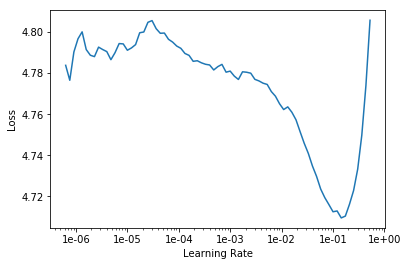

In [8]:
learn.lr_find()
learn.recorder.plot(skip_end=15)
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
learn.save_encoder('fine_tuned_enc')

#### TextClasDataBunch

In [9]:
data_clas = (TextList.from_csv(path, 'texts.csv', col='text',vocab=data_lm.vocab)
                .random_split_by_pct(0.1) 
                .label_from_df(cols=0)
                .databunch())
data_clas.save('tmp_clas')

In [8]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=50)
data_clas.show_batch(rows = 3)

text,label
"xxfld 1 raising victor vargas : a review \n\n you know , raising victor vargas is like sticking your hands into a big , xxunk bowl of xxunk . it 's warm and gooey , but you 're not sure if it feels right . try as i might ,",negative
"xxfld 1 xxup the xxup shop xxup around xxup the xxup xxunk is one of the xxunk and most feel - good romantic comedies ever made . there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words",positive
"xxfld 1 now that che(2008 ) has finished its relatively short australian cinema run ( extremely limited xxunk screen in xxunk , after xxunk ) , i can xxunk join both xxunk of "" at the movies "" in taking steven soderbergh to task . \n\n it 's usually satisfying",negative


### Failed test case: existing `fbeta` is only for multiclassification  
  
`Fbeta` works in the lesson3-planet.ipynb, which is for multiclassification. 

> acc_02 = partial(accuracy_thresh, thresh=0.2)  
f_score = partial(fbeta, thresh=0.2)  
learn = create_cnn(data, arch, metrics=[acc_02, f_score])    
  
It did not work below because in this case it is binary classification. 

In [12]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.metrics = [accuracy,fbeta]

In [13]:
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,fbeta


RuntimeError: The size of tensor a (2) must match the size of tensor b (50) at non-singleton dimension 1

#### Create Fbeta_binary  
To add to metric.py

In [22]:
@dataclass
class Fbeta_binary(Callback):
    "Computes the fbeta between preds and targets for binary classification"
    beta2: int = 2
    eps: float = 1e-9
    
    def on_epoch_begin(self, **kwargs):
        self.TP = 0
        self.total_y_pred = 0   
        self.total_y_true = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        y_pred = last_output               
        y_pred = y_pred.argmax(dim=1)
        y_true = last_target.float()
        
        self.TP += ((y_pred==1) * (y_true==1)).float().sum()
        self.total_y_pred += (y_pred==1).float().sum()
        self.total_y_true += (y_true==1).float().sum()
    
    def on_epoch_end(self, **kwargs):
        beta2=self.beta2**2
        prec = self.TP/(self.total_y_pred+self.eps)
        rec = self.TP/(self.total_y_true+self.eps)       
        res = (prec*rec)/(prec*beta2+rec+self.eps)*(1+beta2)
        self.metric = res 

In [9]:
fbeta_binary = Fbeta_binary(1) # Instantiate to F1

### Passed Test case with `Fbeta_binary`

#### Train text classifier

In [10]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.metrics = [accuracy,fbeta_binary]

In [11]:
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

Total time: 03:09
epoch  train_loss  valid_loss  accuracy  fbeta_binary
1      0.631853    0.716622    0.580000  0.655738      (01:36)
2      0.565523    0.599353    0.670000  0.702703      (01:33)

